In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams["figure.figsize"] = (20, 10)


In [7]:
import pandas as pd
import os

# Path to the folder containing the Parquet files
folder_path = r'C:\Users\Sohum\Downloads\ohlcv processed'

# Dictionaries to store DataFrames
dataframes = {
    'Open': [],
    'High': [],
    'Low': [],
    'Close': [],
    'Volume': []
}

# Function to categorize files based on keywords in file names
def categorize_file(file_name):
    file_name_lower = file_name.lower()
    if 'open' in file_name_lower:
        return 'Open'
    elif 'high' in file_name_lower:
        return 'High'
    elif 'low' in file_name_lower:
        return 'Low'
    elif 'close' in file_name_lower:
        return 'Close'
    elif 'volume' in file_name_lower:
        return 'Volume'
    else:
        return None

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.parquet'):
        category = categorize_file(file_name)
        if category:
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            # Read the Parquet file into a DataFrame
            df = pd.read_parquet(file_path)
            # Append the DataFrame to the corresponding category list
            dataframes[category].append(df)

# Optionally, concatenate DataFrames within each category
for category in dataframes:
    if dataframes[category]:
        dataframes[category] = pd.concat(dataframes[category], ignore_index=False)
    else:
        dataframes[category] = pd.DataFrame()


In [11]:
OPEN = dataframes['Open']
HIGH = dataframes['High']
LOW = dataframes['Low']
CLOSE = dataframes['Close']
VOLUME = dataframes['Volume']


common_indices = OPEN.index.intersection(HIGH.index).intersection(LOW.index).intersection(CLOSE.index).intersection(VOLUME.index)

# Find the common columns (symbols) across all DataFrames
common_columns = OPEN.columns.intersection(HIGH.columns).intersection(LOW.columns).intersection(CLOSE.columns).intersection(VOLUME.columns)

# Keep only the common indices and columns
OPEN = OPEN.loc[common_indices, common_columns]
HIGH = HIGH.loc[common_indices, common_columns]
LOW = LOW.loc[common_indices, common_columns]
CLOSE = CLOSE.loc[common_indices, common_columns]
VOLUME = VOLUME.loc[common_indices, common_columns]


In [83]:
true_range = pd.DataFrame(index=common_indices, columns=common_columns)
for col in common_columns:
    tr1 = HIGH[col] - LOW[col]
    tr2 = (HIGH[col] - CLOSE[col].shift(1)).abs()
    tr3 = (LOW[col] - CLOSE[col].shift(1)).abs()
    true_range[col] = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

atr = true_range.rolling(window=14).mean()


In [85]:
ATR = atr

In [13]:
dates = sorted(list(set(OPEN.index.date)))

In [380]:
import pandas as pd

import pandas as pd

def process_longs(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR, charges=0.0002, leverage=5, sl_type='trailing'):
    LongBO = todayHIGH.iloc[0:15].max()
    ShortBO = todayLOW.iloc[0:15].min()

    tradeOPEN = todayOPEN.iloc[16:-1]
    tradeATR = todayATR.iloc[16:-1]
    tradeLOW = todayLOW.iloc[16:-1]

    master_lst = []
    for ticker in todayOPEN.columns.to_list():
        ticker_long_BO = LongBO[ticker]
        ticker_short_BO = ShortBO[ticker]
        lst = []

        for i in range(len(tradeOPEN) - 15):
            if tradeOPEN[ticker][i] >= ticker_long_BO and i < 16:
                LongEntry = tradeOPEN[ticker][i]
                LongEntryTime = tradeOPEN.index[i]
                SL = todayLOW[ticker][15 + i] - 1.5 * tradeATR[ticker][15 + i]
                points = LongEntry - SL
                TGT = LongEntry + 2 * points
                
                if sl_type == 'trailing':
                    for k in range(16 + i, len(todayOPEN)):
                        if k >= len(tradeOPEN) - 1:
                            ExitPrice = tradeOPEN[ticker][k - 1]
                            LongExitTime = tradeOPEN.index[k - 1]
                            lst.append({
                                'Stock': ticker,
                                'LongEntryTime': LongEntryTime,
                                'LongEntry': LongEntry,
                                'LongExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        if tradeOPEN[ticker][k] <= SL:
                            ExitPrice = tradeOPEN[ticker][k]
                            LongExitTime = tradeOPEN.index[k]
                            lst.append({
                                'Stock': ticker,
                                'LongEntryTime': LongEntryTime,
                                'LongEntry': LongEntry,
                                'LongExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        elif tradeOPEN[ticker][k] >= TGT:
                            TGT += points
                            SL += points

                    break

                else:  # for fixed SL
                    for k in range(16 + i, len(todayOPEN)):
                        if k >= len(tradeOPEN) - 1:
                            ExitPrice = tradeOPEN[ticker][k - 1]
                            LongExitTime = tradeOPEN.index[k - 1]
                            lst.append({
                                'Stock': ticker,
                                'LongEntryTime': LongEntryTime,
                                'LongEntry': LongEntry,
                                'LongExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        if tradeOPEN[ticker][k] <= SL or tradeOPEN[ticker][k] >= TGT:
                            ExitPrice = tradeOPEN[ticker][k]
                            LongExitTime = tradeOPEN.index[k]
                            lst.append({
                                'Stock': ticker,
                                'LongEntryTime': LongEntryTime,
                                'LongEntry': LongEntry,
                                'LongExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                    break

        if len(lst):
            master_lst.extend(lst)

    if master_lst:
        Trades = pd.DataFrame(master_lst).sort_values('LongEntryTime')
        Trades['Profit'] = Trades['ExitPrice'] / Trades['LongEntry'] - 1
        Trades['Profit'] = Trades['Profit'] - (2 + Trades['Profit']) * charges
        Trades['Profit'] *= leverage

        return Trades
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no trades were executed



def process_shorts(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR, charges=0.0002, leverage=5, sl_type='trailing'):
    ShortBO = todayLOW.iloc[0:15].min()
    Trades = pd.DataFrame()
    tradeOPEN = todayOPEN.iloc[16:-1]
    tradeATR = todayATR.iloc[16:-1]
    tradeLOW = todayLOW.iloc[16:-1]
    tradeHIGH = todayHIGH.iloc[16:-1]

    master_lst = []
    for ticker in todayOPEN.columns.to_list():
        ticker_short_BO = ShortBO[ticker]
        lst = []

        for i in range(len(tradeOPEN) - 15):
            if tradeOPEN[ticker][i] <= ticker_short_BO and i < 50:
                
                LongEntry = tradeOPEN[ticker][i]
                LongEntryTime = tradeOPEN.index[i]
                SL = todayHIGH[ticker][15 + i] + 1.5 * tradeATR[ticker][15 + i]
                points = -1 * (LongEntry - SL)
                TGT = LongEntry - 2 * points

                if sl_type == 'trailing':
                    for k in range(16 + i, len(todayOPEN)):
                        if k >= len(tradeOPEN) - 1:
                            ExitPrice = tradeOPEN[ticker][k - 1]
                            LongExitTime = tradeOPEN.index[k - 1]
                            lst.append({
                                'Stock': ticker,
                                'ShortEntryTime': LongEntryTime,
                                'ShortEntry': LongEntry,
                                'ShortExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        if tradeOPEN[ticker][k] >= SL:
                            ExitPrice = tradeOPEN[ticker][k]
                            LongExitTime = tradeOPEN.index[k]
                            lst.append({
                                'Stock': ticker,
                                'ShortEntryTime': LongEntryTime,
                                'ShortEntry': LongEntry,
                                'ShortExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        elif tradeOPEN[ticker][k] <= TGT:
                            TGT -= points
                            SL -= points

                    break

                else:  
                    for k in range(16 + i, len(todayOPEN)):
                        if k >= len(tradeOPEN) - 1:
                            ExitPrice = tradeOPEN[ticker][k - 1]
                            LongExitTime = tradeOPEN.index[k - 1]
                            lst.append({
                                'Stock': ticker,
                                'ShortEntryTime': LongEntryTime,
                                'ShortEntry': LongEntry,
                                'ShortExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                        if tradeOPEN[ticker][k] >= SL or tradeOPEN[ticker][k] >= TGT:
                            ExitPrice = tradeOPEN[ticker][k]
                            LongExitTime = tradeOPEN.index[k]
                            lst.append({
                                'Stock': ticker,
                                'ShortEntryTime': LongEntryTime,
                                'ShortEntry': LongEntry,
                                'ShortExitTime': LongExitTime,
                                'ExitPrice': ExitPrice,
                            })
                            break

                    break



        if len(lst):
            master_lst.extend(lst)

    if master_lst:
        Trades = pd.DataFrame(master_lst).sort_values('ShortEntryTime')
        Trades['Profit'] = Trades['ExitPrice'] / Trades['ShortEntry'] - 1
        Trades['Profit'] = Trades['Profit'] - (2 + Trades['Profit']) * charges
        Trades['Profit'] *= -5

        return Trades
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no trades were executed


In [381]:
process_shorts(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR)

,Stock,ShortEntryTime,ShortEntry,ShortExitTime,ExitPrice,Profit
30,IOC.NS,2022-01-11 09:31:00,71.45,2022-01-11 15:27:00,71.10,0.026488
35,M&M.NS,2022-01-11 09:31:00,836.25,2022-01-11 15:06:00,843.35,-0.040443
15,CHOLAFIN.NS,2022-01-11 09:31:00,560.20,2022-01-11 10:31:00,560.75,-0.002908
33,KOTAKBANK.NS,2022-01-11 09:32:00,1934.00,2022-01-11 11:05:00,1944.00,-0.023848
29,INDUSINDBK.NS,2022-01-11 09:32:00,920.60,2022-01-11 10:32:00,921.20,-0.001258
27,ICICIBANK.NS,2022-01-11 09:32:00,806.90,2022-01-11 12:58:00,810.60,-0.020923
26,HINDALCO.NS,2022-01-11 09:32:00,491.10,2022-01-11 15:27:00,486.05,0.053405
38,PNB.NS,2022-01-11 09:32:00,39.90,2022-01-11 10:22:00,40.15,-0.029322
32,JINDALSTEL.NS,2022-01-11 09:32:00,393.10,2022-01-11 09:48:00,395.85,-0.032971
2,ADANIPORTS.NS,2022-01-11 09:33:00,733.10,2022-01-11 11:33:00,736.00,-0.017775


In [346]:
def filter_dates_by_years(dates, start_year, end_year):
    # Ensure dates are in pandas datetime format
    dates = pd.to_datetime(dates)
    
    # Filter dates within the specified year range
    filtered_dates = [date for date in dates if start_year <= date.year <= end_year]
    return pd.to_datetime(filtered_dates).date
   

In [347]:
dates = sorted(list(set(OPEN.index.date)))

In [348]:
dates=filter_dates_by_years(dates,2022,2025)

In [355]:
process_longs

<function __main__.process_longs(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR, charges=0.0002, leverage=5, sl_type='trailing')>

In [ ]:
short_positions = 50
long_positions = 25
lst=[]
for i in tqdm(range(len(dates))):
    todayOPEN = OPEN[OPEN.index.date == dates[i]]
    todayHIGH = HIGH[HIGH.index.date == dates[i]]
    todayLOW = LOW[LOW.index.date == dates[i]]
    todayCLOSE = CLOSE[CLOSE.index.date == dates[i]]
    todayVOLUME = VOLUME[VOLUME.index.date == dates[i]]
    todayATR  = ATR[ATR.index.date == dates[i]]

    #TradeDFLong = process_longs(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR).head(25)
    try:
        TradeDFShort = process_shorts(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR,sl_type='fixed').head(long_positions)
        TradeDFLong = process_shorts(todayOPEN, todayHIGH, todayLOW, todayCLOSE, todayVOLUME, todayATR,sl_type='trailing').head(long_positions)
        lst.append({'Date': dates[i],
                     'Returns Long Trailing': TradeDFLong['Profit'].sum()/long_positions,
                     'Returns Long Fixed': TradeDFShort['Profit'].sum()/long_positions})
        
    except Exception as e:
        print(e)

  0%|          | 0/605 [00:00<?, ?it/s]

In [357]:
FinalTrades = pd.DataFrame(lst).set_index('Date')
FinalTrades.index = pd.to_datetime(FinalTrades.index)

<Axes: xlabel='Date'>

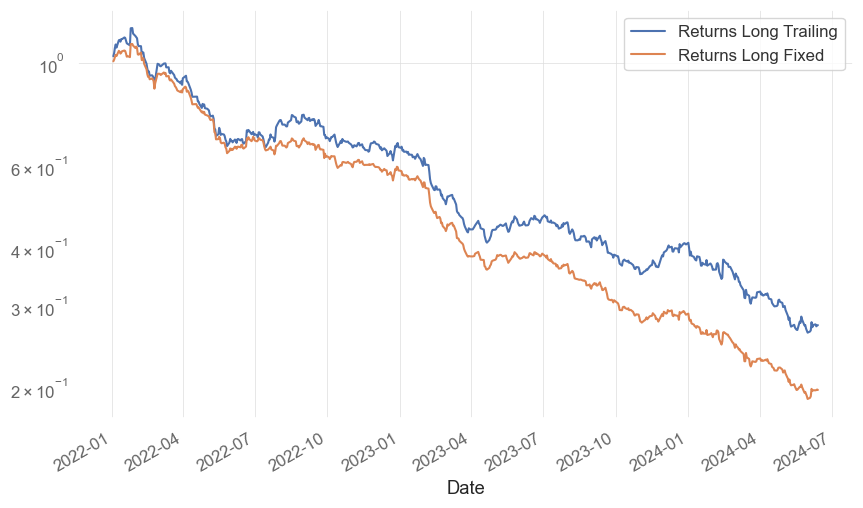

In [358]:
(1+FinalTrades).cumprod().plot(logy=True)

                           Strategy
-------------------------  ----------
Start Period               2020-01-01
End Period                 2024-06-13
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          576.99%
CAGR﹪                     34.53%

Sharpe                     1.49
Prob. Sharpe Ratio         99.97%
Smart Sharpe               1.34
Sortino                    2.91
Smart Sortino              2.62
Sortino/√2                 2.06
Smart Sortino/√2           1.85
Omega                      1.37

Max Drawdown               -23.63%
Longest DD Days            272
Volatility (ann.)          32.86%
Calmar                     1.46
Skew                       2.07
Kurtosis                   12.74

Expected Daily %           0.17%
Expected Monthly %         3.61%
Expected Yearly %          46.59%
Kelly Criterion            11.46%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.21%
Expected Shortfall (cVaR)  -3.21%

Max Consecutive Wins  

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-03-30,2020-06-23,2020-10-23,208,-23.630545,-22.161957
2,2023-04-24,2023-08-16,2024-01-20,272,-16.564246,-16.367705
3,2021-04-08,2021-10-05,2021-11-17,224,-14.310586,-14.034678
4,2024-05-10,2024-06-11,2024-06-13,35,-13.850126,-13.549828
5,2020-10-27,2021-01-08,2021-04-01,157,-13.575945,-12.995659


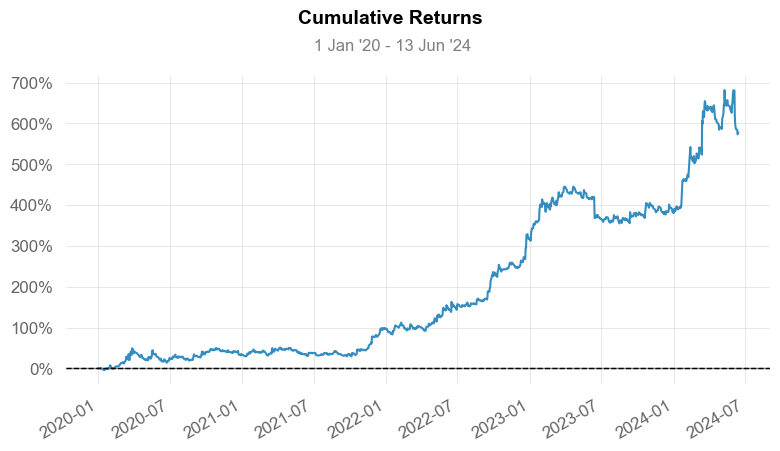

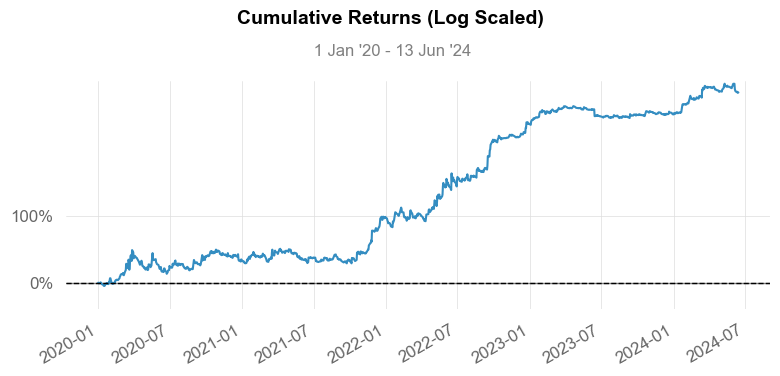

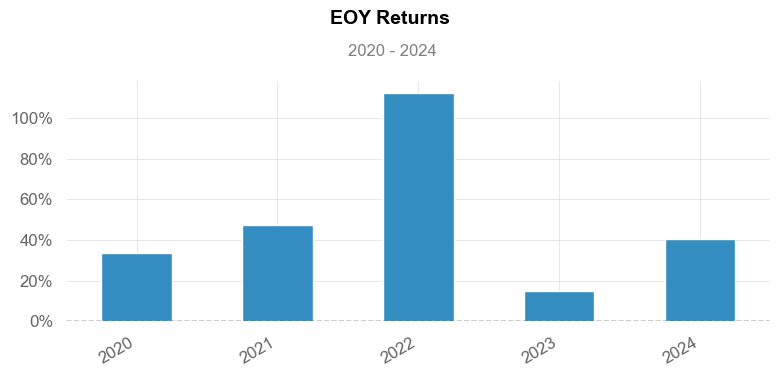

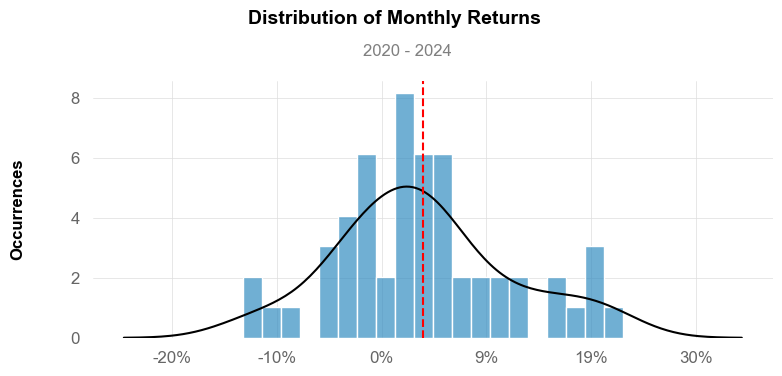

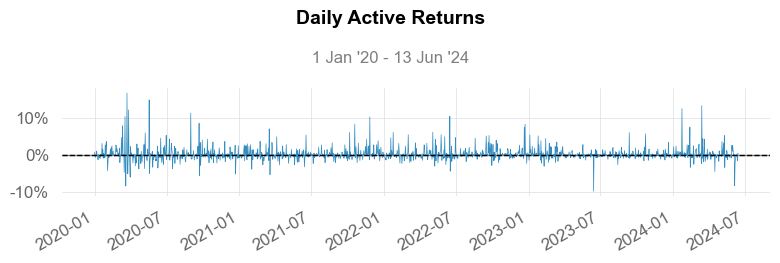

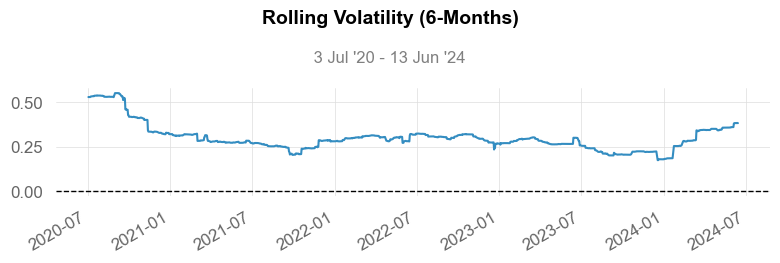

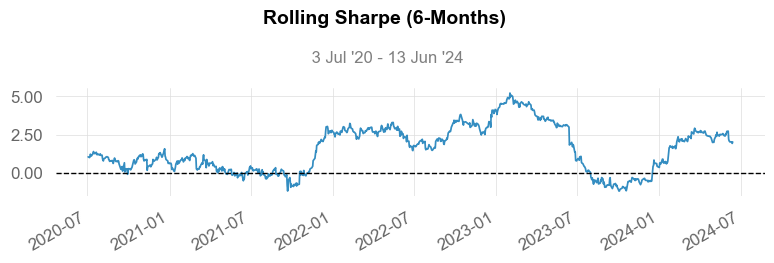

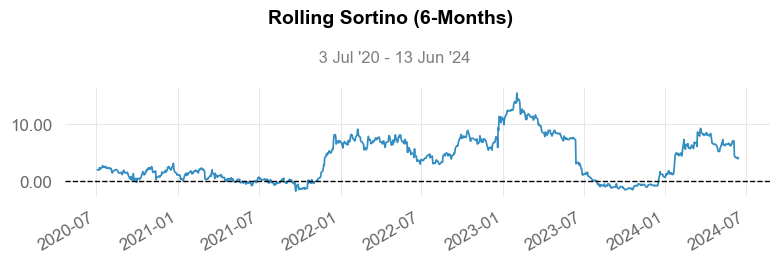

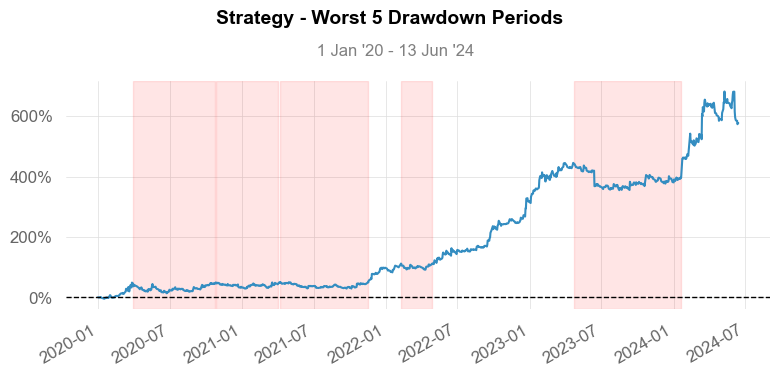

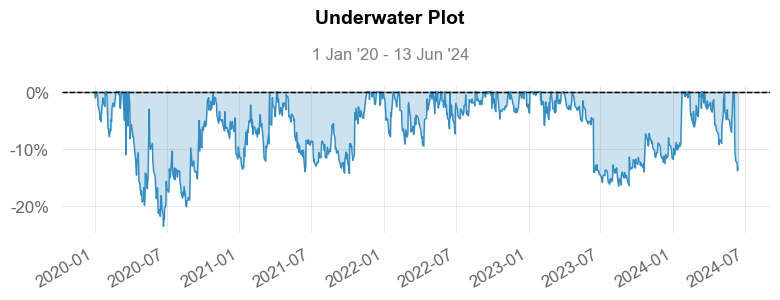

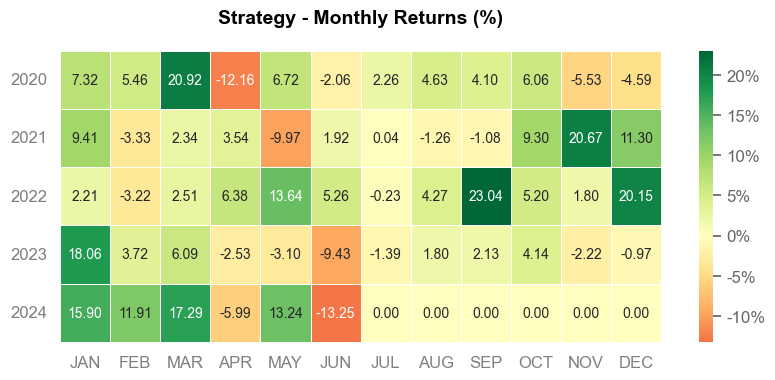

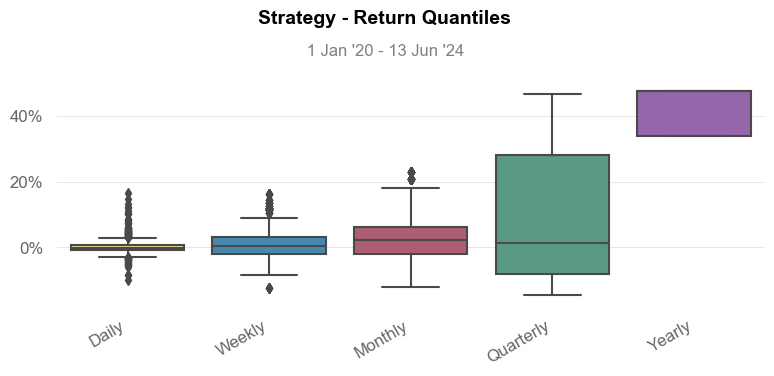

In [325]:
import quantstats as qs
qs.reports.full(FinalTrades['Returns Short'])